In [1]:
import os
os.chdir(os.path.abspath(".."))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

from dataio import load_metadataset, load_rmses
from metamodel import build_baseline, build_regression_topline

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from MCM import MCM

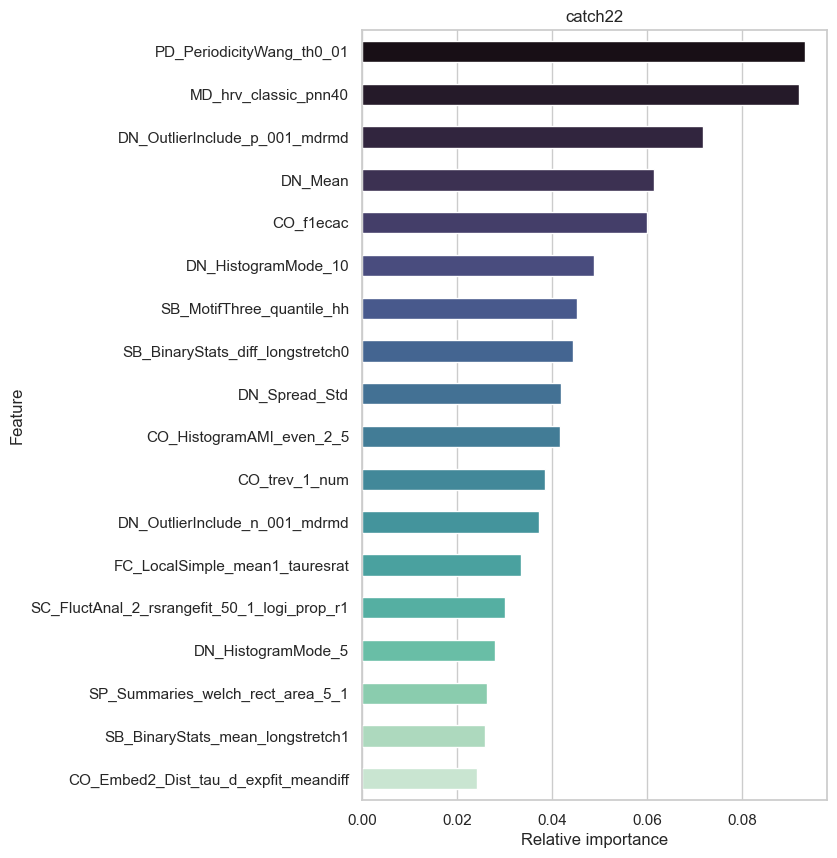

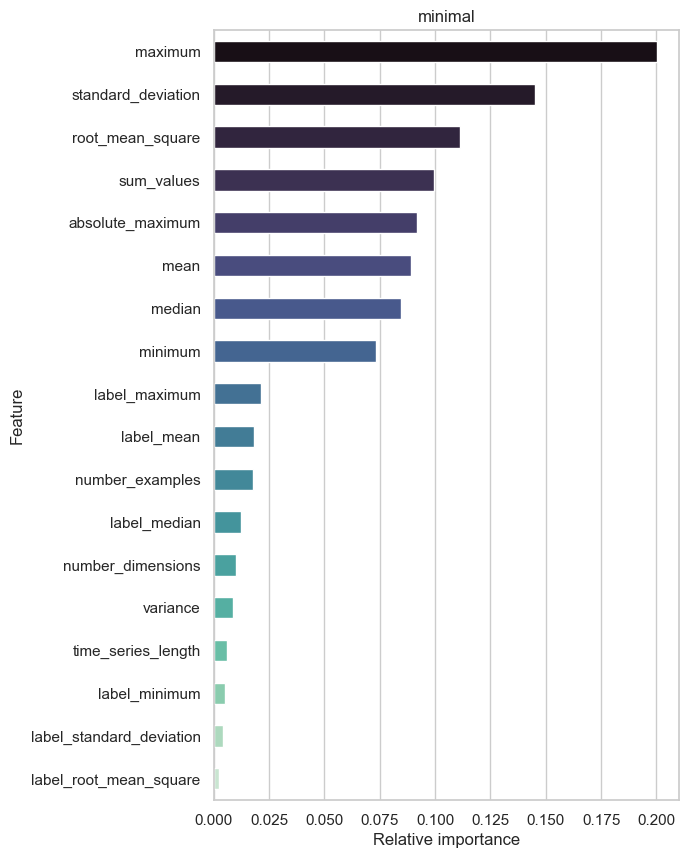

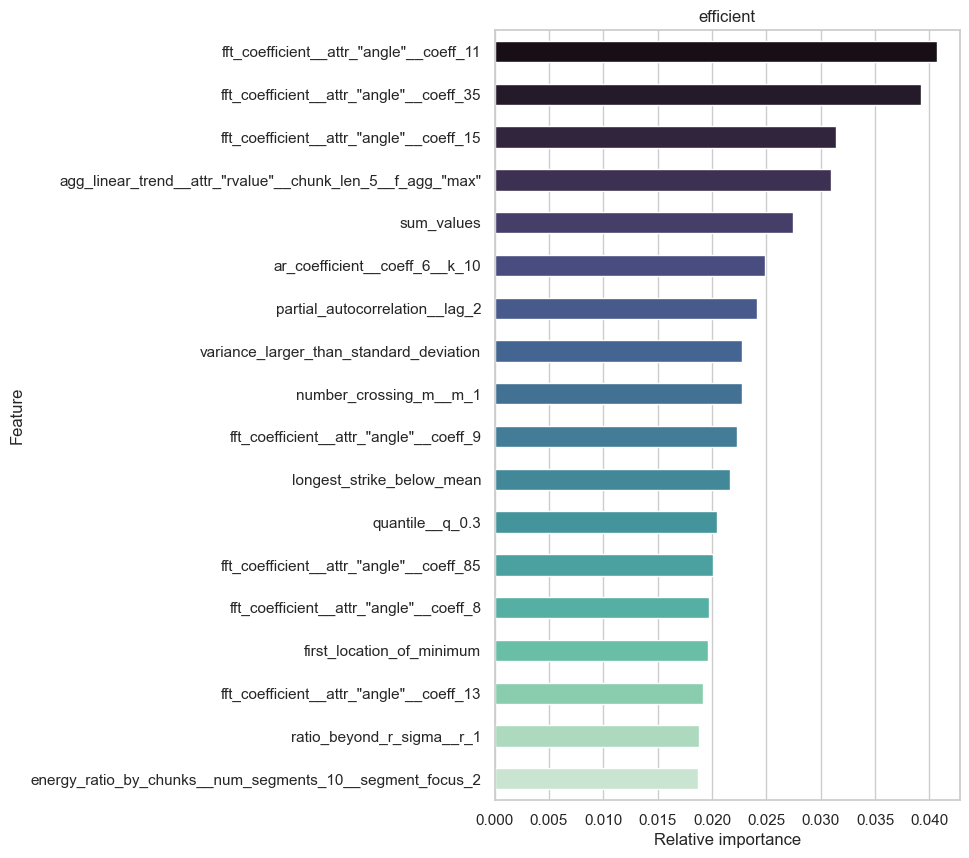

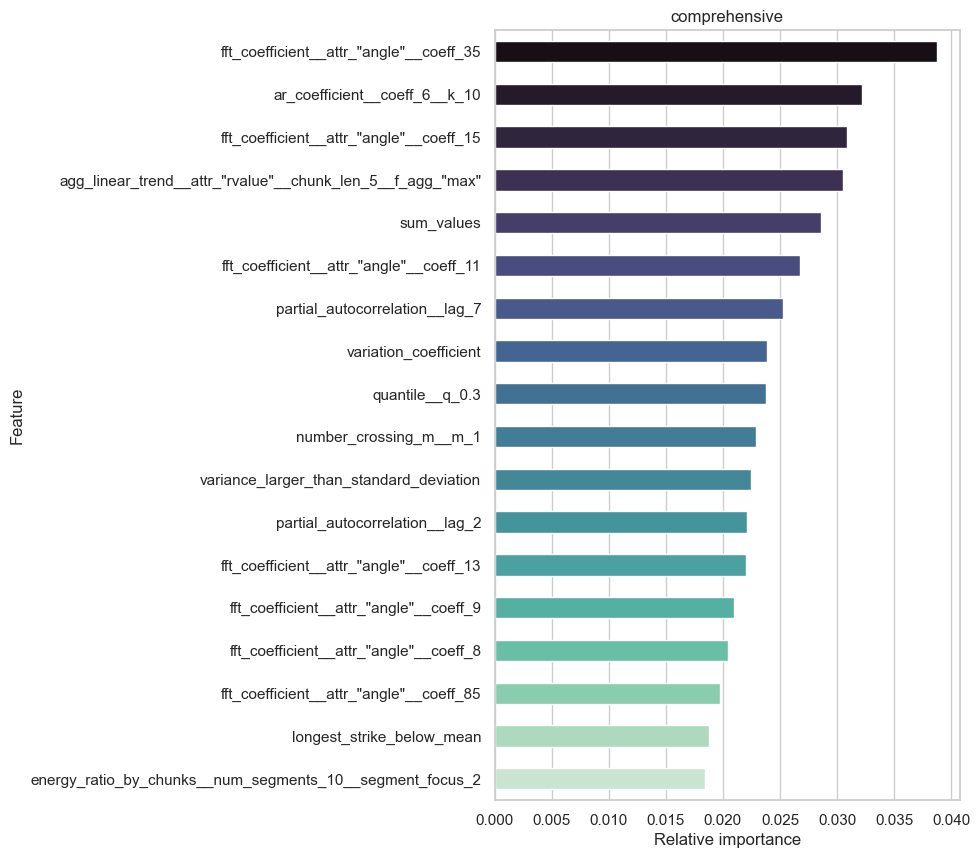

In [3]:
sns.set_theme(style="whitegrid")

feature_set_importances = dict()

for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    meta_X, meta_y = load_metadataset(feature_set, problem_type="regression")
    y_encoder = LabelEncoder().fit(meta_y)
    meta_y_encoded = y_encoder.transform(meta_y)

    xgb = XGBClassifier().fit(meta_X, meta_y_encoded)
    feature_importances = xgb.feature_importances_
    
    importance_map = dict()
    for fname, fimp in zip(meta_X.columns, feature_importances):
        fname_split = fname.split("_")
        if fname_split[0] in ["mean", "std", "median", "q1", "q3", "max", "min"]:
            fname_proper = "_".join(fname_split[1:])
            importance_map[fname_proper] = fimp + importance_map.get(fname_proper, 0.)
        else:
            importance_map[fname] = fimp + importance_map.get(fname, 0.)

    imps = np.array(list(importance_map.values()))
    names = np.array(list(importance_map.keys()))
    order = np.argsort(-imps)

    feature_set_importances[feature_set] = {
        "name": names[order],
        "importance": imps[order]
    }

n_features = 18
for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    fig, ax = plt.subplots(figsize=(6, 10))

    sns.barplot(
        x=feature_set_importances[feature_set]["importance"][:n_features],
        y=feature_set_importances[feature_set]["name"][:n_features],
        palette="mako",
        width=0.5,
        ax=ax
    )
    ax.set_xlabel("Relative importance")
    ax.set_ylabel("Feature")
    ax.set_title(feature_set)

    plt.show()

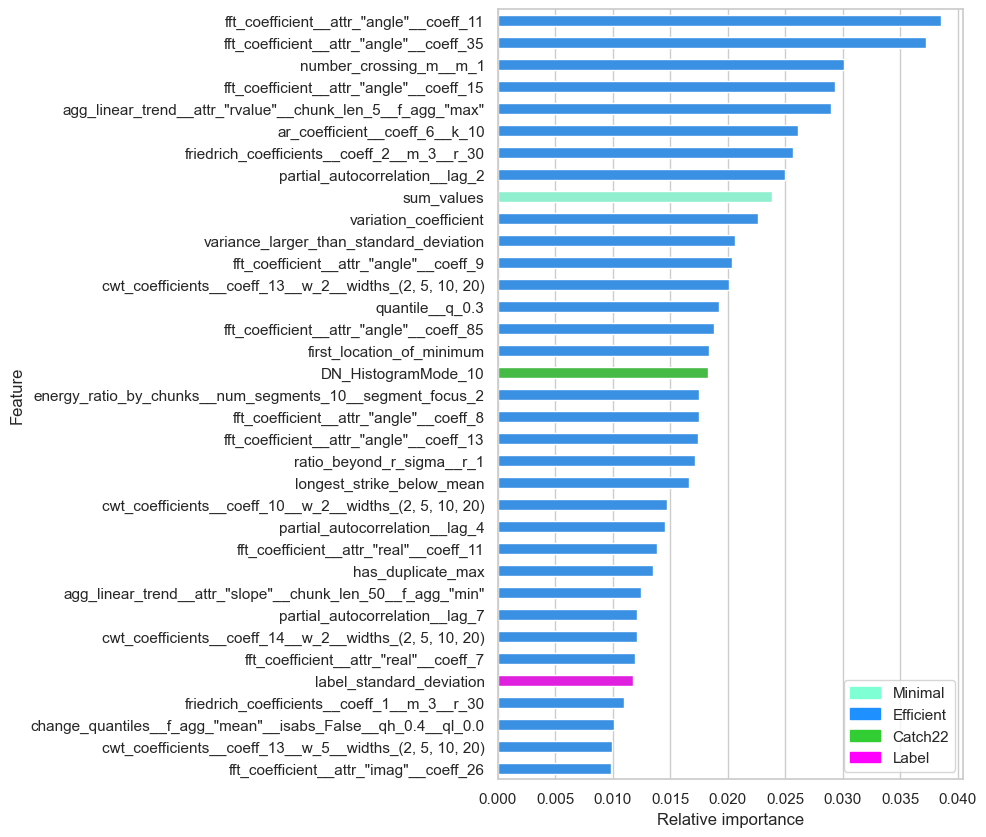

In [4]:
meta_X_tsfresh, meta_y = load_metadataset("comprehensive", "regression")
meta_X_catch22, _ = load_metadataset("catch22", "regression")
meta_X = pd.concat([meta_X_tsfresh, meta_X_catch22], axis=1)
meta_X = meta_X.T.drop_duplicates().T

y_encoder = LabelEncoder().fit(meta_y)
meta_y_encoded = y_encoder.transform(meta_y)

xgb = XGBClassifier().fit(meta_X, meta_y_encoded)
feature_importances = xgb.feature_importances_

importance_map = dict()
for fname, fimp in zip(meta_X.columns, feature_importances):
    fname_split = fname.split("_")
    if fname_split[0] in ["mean", "std", "median", "q1", "q3", "max", "min"]:
        fname_proper = "_".join(fname_split[1:])
        importance_map[fname_proper] = fimp + importance_map.get(fname_proper, 0.)
    else:
        importance_map[fname] = fimp + importance_map.get(fname, 0.)

imps = np.array(list(importance_map.values()))
names = np.array(list(importance_map.keys()))
order = np.argsort(-imps)

hue = list()
for name in names:
    if name in ["number_examples", "number_dimensions", "time_series_length"]:
        hue.append("General")
    elif name.startswith("label_"):
        hue.append("Label")
    elif name in feature_set_importances["catch22"]["name"]:
        hue.append("Catch22")
    elif name in feature_set_importances["minimal"]["name"]:
        hue.append("Minimal")
    elif name in feature_set_importances["efficient"]["name"]:
        hue.append("Efficient")
    else:
        hue.append("Comprehensive")
hue = np.array(hue)
colors = {
    "Minimal": "aquamarine",
    "Efficient": "dodgerblue",
    #"Comprehensive": "midnightblue",
    "Catch22": "limegreen",
    #"General": "red",
    "Label": "magenta"
}

n_features = 35
fig, ax = plt.subplots(figsize=(6, 10))
sns.barplot(
    x=imps[order][:n_features],
    y=names[order][:n_features],
    width=0.5,
    palette=[colors[h] for h in hue[order][:n_features]],
    ax=ax
)
ax.set_xlabel("Relative importance")
ax.set_ylabel("Feature")
ax.legend(
    [plt.Rectangle((0,0), 1, 1, color=colors[label]) for label in colors.keys()],
    colors.keys()
)

plt.show()

In [5]:
print("--- Best estimator accuracies ---")

for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    accs = np.empty(5)
    for i in range(5):
        results = pd.read_csv(f"./results/regression/{feature_set}/xgb/regression_label_{feature_set}_xgb_{i+1}.csv")
        accs[i] = accuracy_score(results["best_estimator"], results["predicted_estimator"])
    
    print(f"{feature_set}: {100 * np.mean(accs):.5f}%")

--- Best estimator accuracies ---
catch22: 32.25806%
minimal: 37.09677%
efficient: 37.09677%
comprehensive: 38.70968%


In [6]:
rmses = load_rmses()
results = dict()
for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
    rmse = None
    for i in range(5):
        res = pd.read_csv(f"./results/regression/{feature_set}/xgb/regression_label_{feature_set}_xgb_{i+1}.csv")
        if rmse is None:
            rmse = res["rmse"]
        else:
            rmse = rmse + res["rmse"]
    rmse = rmse / 5

    results[feature_set] = rmse

results["datasets"] = res["dataset"]
results["baseline"] = build_baseline(rmses)
results["topline"] = build_regression_topline(rmses) - 1e-15

results = pd.DataFrame(results).set_index("datasets")
results_normalized = (results.T / (results.T + results.T.median())).T
results_normalized

,catch22,minimal,efficient,comprehensive,baseline,topline
datasets,,,,,,
AcousticContaminationMadrid-no-missing,0.490362,0.436430,0.520679,0.520679,0.509280,0.436430
AluminiumConcentration,0.500000,0.500000,0.500000,0.500000,0.508731,0.488420
AppliancesEnergy,0.500000,0.637769,0.500000,0.500000,0.561846,0.460673
BIDMC32HR,0.500000,0.500000,0.500000,0.500000,0.805113,0.500000
BIDMC32RR,0.500000,0.500000,0.500000,0.500000,0.672482,0.495942
...,...,...,...,...,...,...
TetuanEnergyConsumption,0.500000,0.500000,0.500000,0.500000,0.660196,0.487714
VentilatorPressure,0.615236,0.500000,0.500000,0.500000,0.676440,0.500000
WaveDataTension,0.497170,0.497713,0.523579,0.523579,0.502266,0.492734


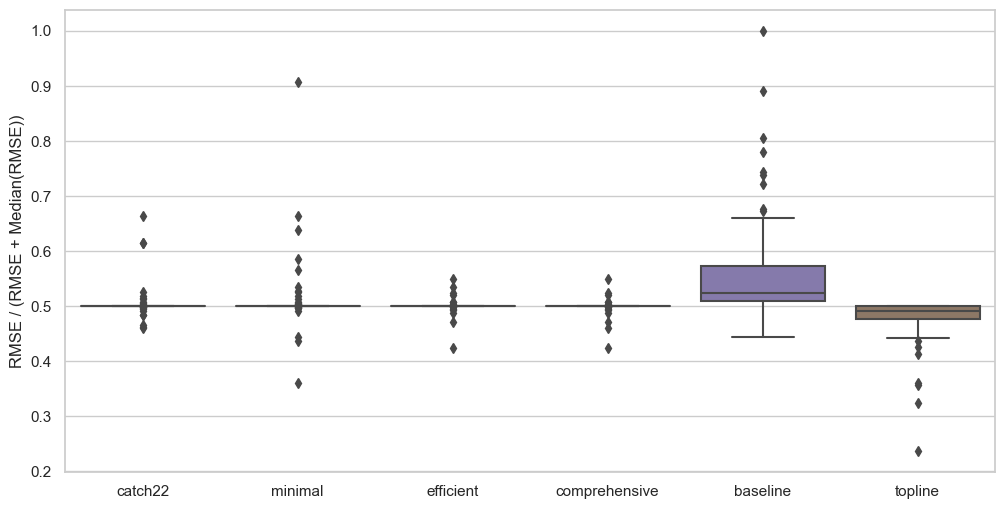

In [7]:
sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(12,6))

sns.boxplot(data=results_normalized, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("RMSE / (RMSE + Median(RMSE))")

plt.show()

Processing topline, baseline:   0%|          | 0/6 [00:00<?, ?it/s]       


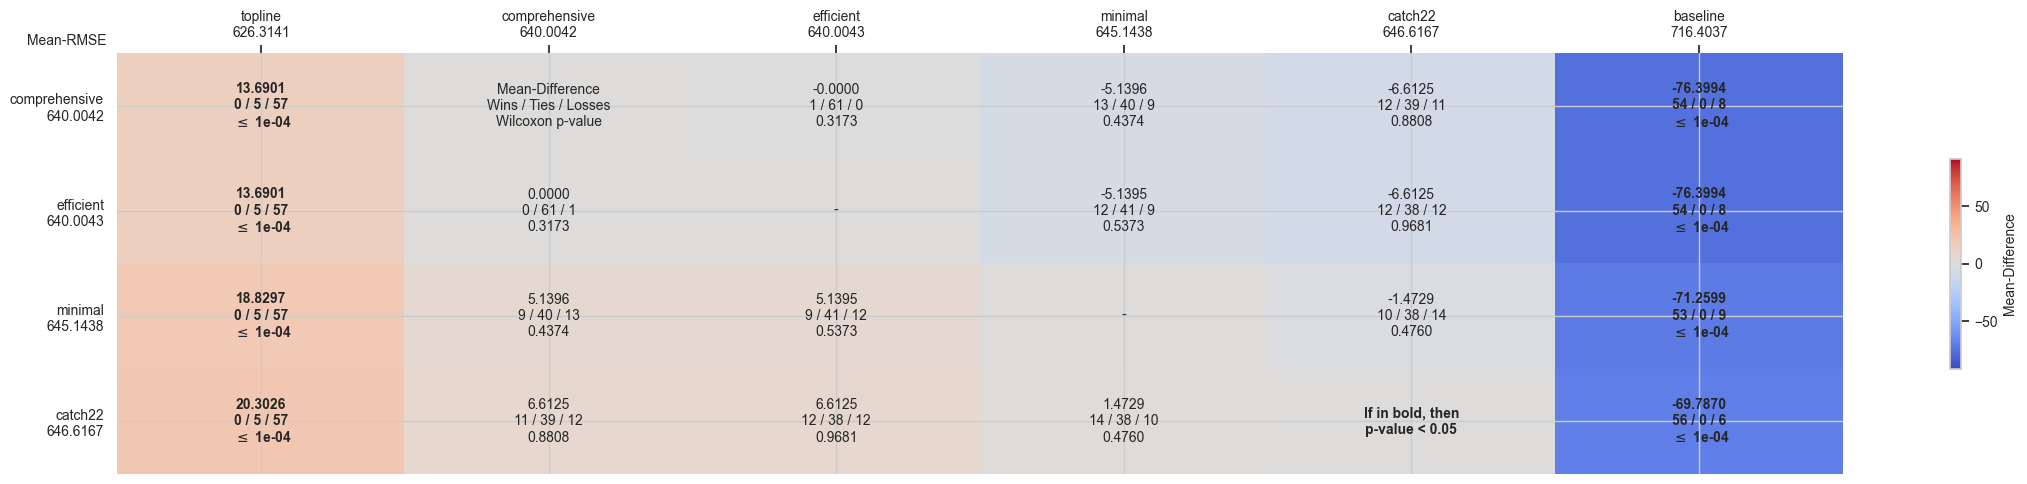

In [8]:
MCM.compare(
    df_results=results,
    output_dir="results/",
    used_statistic="RMSE",
    order_WinTieLoss="lower",
    order_better="increasing",
    save_as_json=False,
    win_label="Wins",
    tie_label="Ties",
    loss_label="Losses",
    colormap="coolwarm",
    excluded_row_comparates=["baseline", "topline"],
    colorbar_orientation="vertical",
)

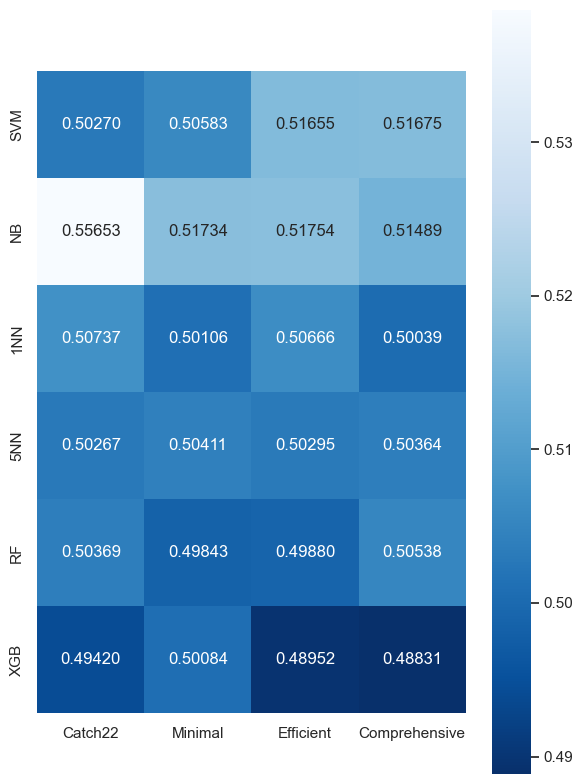

In [9]:
results = dict()
for model in ["svm", "nb", "1nn", "5nn"]:
    for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
        res = pd.read_csv(f"results/regression/{feature_set}/regression_label_{feature_set}_{model}.csv")
        results[f"{model}-{feature_set}"] = res["rmse"]

for model in ["rf", "xgb"]:
    for feature_set in ["catch22", "minimal", "efficient", "comprehensive"]:
        rmse = None
        for i in range(5):
            res = pd.read_csv(f"results/regression/{feature_set}/{model}/regression_label_{feature_set}_{model}_{i+1}.csv")
            if rmse is None:
                rmse = res["rmse"]
            else:
                rmse = rmse + res["rmse"]
        rmse = rmse / 5
        results[f"{model}-{feature_set}"] = rmse

rmses = load_rmses()
results["datasets"] = rmses.columns

results = pd.DataFrame(results).set_index("datasets")
results_normalized = (results.T / (results.T + results.T.median())).T

models = ["SVM", "NB", "1NN", "5NN", "RF", "XGB"]
features = ["Catch22", "Minimal", "Efficient", "Comprehensive"]
heatmap = np.empty((len(models), len(features)))

for i, m in enumerate(models):
    for j, f in enumerate(features):
        heatmap[i,j] = results_normalized[f"{m.lower()}-{f.lower()}"].mean()

heatmap = pd.DataFrame(heatmap)
heatmap.index = models
heatmap.columns = features

fig, ax = plt.subplots(figsize=(6,8))

sns.heatmap(
    heatmap,
    cmap="Blues_r",
    annot=True,
    fmt=".5f",
    robust=True,
    square=True,
    ax=ax
)

plt.show()